In [4]:
import numpy as np
import matplotlib.pyplot as plt

from dimod import BinaryQuadraticModel, BINARY
from dwave.system import DWaveSampler, EmbeddingComposite

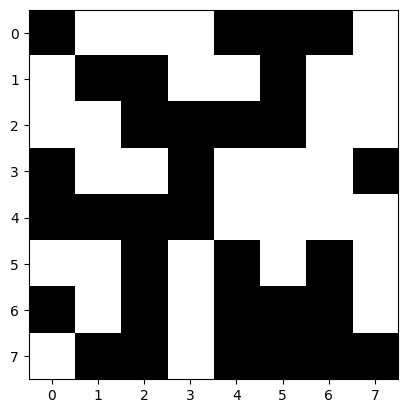

In [25]:
# Lattice config
nn = 2**3
N = nn**2

# Groups
A = N//2 # n -> 50%
B = A    # m -> 50%
initial_group_bias = 1

# Constraints weights
l_e = 4*N**2  # Equality constraint sum(A)=n & sum(B)=m
l_n = 2   # Different neighbor cell constraint weight

# Generate random lattice
linear = np.concatenate((np.zeros(A), np.ones(B)))
np.random.shuffle(linear)

plt.imshow(linear.reshape((nn, nn)), cmap='gray', interpolation='nearest')
plt.show()


In [36]:
bqm = BinaryQuadraticModel.empty(vartype=BINARY)

# Initial State or input
bqm.add_variables_from(
    [(i, linear[i] + initial_group_bias) for i in range(N)]
)

# Constraints
bqm.add_linear_equality_constraint(
    terms=[(i, linear[i]) for i in range(N)],
    lagrange_multiplier=l_e, # weight of conservation constraint
    constant=B               # we must maintain the number of 1s
)

# Objective function
for i in range(nn):
    for j in range(nn):
        # 8-nearest neighbors
        for k in range(-1, 2):
            new_i = ((k+i) % nn) * nn

            # l_n * (x_{ij}-x_{(i+k)(j+l)})^2
            for l in range(-1, 2):
                if (k==0 and l==0) or (): continue
                ij = i*nn + j
                new_ij = new_i + (l+j) % nn
                if ij == new_ij: continue

                bqm.add_linear(ij, l_n)
                bqm.add_linear(new_ij, l_n)
                bqm.add_interaction(ij, new_ij, -2*l_n)


In [ ]:
sampler = EmbeddingComposite(DWaveSampler(
    token="token"
))
response = sampler.sample(bqm, num_reads=50)

In [ ]:
num_results = len(response)

num_ones = []

rows = 5 # Ajusta según el número de resultados
cols = 10 # Ajusta según el número de resultados

fig, axes = plt.subplots(rows, cols, figsize=(15, 8)) 

# Flatten axes para iterar fácilmente
axes = axes.flatten()

for i, sample in enumerate(response.data()):
  solution = np.array(list(sample.sample.values()))
  
  num_ones.append(np.count_nonzero(solution == 1))
  
  axes[i].imshow(solution.reshape((nn, nn)), cmap='gray', interpolation='nearest')
  axes[i].set_title(f'Sample {i+1}')
  axes[i].axis('off')

# Ocultar subplots vacíos si no son 50 resultados
for i in range(num_results, rows*cols):
  axes[i].axis('off')

plt.tight_layout() 
plt.show()

In [ ]:
for sample in response.data():
  solution = np.array(list(sample.sample.values()))
  num_ones.append(np.count_nonzero(solution == 1))

print(num_ones)

plt.hist(num_ones, bins=10)
plt.axvline(x=B, color='r', linestyle='--')
plt.xlabel('Number of 1s')
plt.ylabel('Frequency')
plt.title('Histogram of number of 1s in the solutions')
plt.ylim(0, 100)
plt.show()

In [ ]:
minimum_energy_samples = response.lowest()
sample = minimum_energy_samples.first.sample 
solution = np.array(list(sample.values()))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(linear.reshape((nn, nn)), cmap='gray', interpolation='nearest')
axes[0].set_title('Initial State')
axes[0].set_xticks([])
axes[0].set_yticks([])


axes[1].imshow(solution.reshape((nn, nn)), cmap='gray', interpolation='nearest')
axes[1].set_title('Solution')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()